In [1]:
import pandas as pd
import numpy as np
from maxijdefs import *
import matplotlib.pyplot as plt
import matplotlib
# from matplotlib import ticker
%matplotlib inline

In [2]:
def lc_detrend(photin):
    photout=np.zeros(len(photin))
    for i in range(len(photin)):
        i1=i-500
        i2=i+500
        if i1<0:
            i1=0
        if i2>len(photin):
            i2=len(photin)
        photout[i]=photin[i]-np.median(photin[i1:i2])

    return photout

In [3]:
def photlc_2_ts(t5,maxiphot5):
    # takes t, phot and turns it into a time series
    
    dt=(np.max(t5)-np.min(t5)).astype(int)
    print dt
    f=np.zeros(dt+1)
    
    t0=(t5-np.min(t5)).astype(int)
    f[t0]=maxiphot5[:]
    
    return f

In [4]:
def logbin(f,p,df):
    #df = step size in log frequency
    fx=np.zeros(len(f))
    px=np.zeros(len(p))
    fx[:]=f[:]
    fx[0]=fx[1]
    p0=p[0]
    px[:]=p[:]
    px[0]=0.

    fl=np.log10(fx)
    nel=len(f)

    fmin=fl[1]
    fmax=np.max(fl)

    nf=np.round((fmax-fmin)/df).astype(int)
    f2=np.arange(nf)*df+fmin
    p2=np.zeros(nf)

    for i in range(nf):
        fa=10.**f2[i]
        fb=10.**(f2[i]+df)
        fm=(fa+fb)/2.0
        dff=fm-fa
        if len(f[np.abs(f-fm)<=dff])>0:
            p2[i]=np.mean(px[np.abs(f-fm)<=dff])

    return f2,p2

In [5]:
def tsclean(tsin,fluxmin):
    # interpolates over gaps in time series
    # gaps defined by <fluxmin
    
    n=len(tsin)
    tsout=np.zeros(n)
    tsout[tsin>=fluxmin]=tsin[tsin>=fluxmin]
    index_bad=np.argwhere(tsin<fluxmin)
    index_good=np.argwhere(tsin >=fluxmin)
    x=np.arange(n)
    index_fixed=list()
    
    for i in index_bad:
        if int(i) not in index_fixed:
            
            n1=i[0]-1 #last good data point
            dindex=index_good-i
            n2=np.min(index_good[dindex>0]) # get the minimum value
            dn=n2-n1
            df=tsin[n2]-tsin[n1]
            #print df/dn
            tsout[n1:n2]=tsin[n1]+(df/dn)*np.arange(dn.astype(int))
        
            for j in np.arange(n1,n2):
                index_fixed.append(int(j))
        
    return tsout

In [6]:
def pds_chunk128(t,flx,t1,t2):
    # takes time series - not lightcurve - time and flx
    # extracts time from t1 to t2
    # calculates power spectrum in 128s segments and returns
    
    t_span=t2-t1
    n_chunk=np.round(t_span/128.0).astype(int)
    
    print t_span, n_chunk
    
    dt2=128.0/2.0 # half-width of chunk
    
    for i in range(n_chunk):
        ty=t-((i*dt2*2)+dt2+t1)
        y=flx[np.abs(ty)<=dt2]
        if i==0:
            flen=len(y)/2
            print i, flen
            p=np.zeros([n_chunk,flen])
            f=np.arange(flen)/(dt2*2)
        af=np.fft.fft(y)
        p[i,:]=np.abs(af[:flen])**2
        
    ptot=np.sum(p,axis=0)
    
    return f,p,ptot


In [7]:
def p_2_logp(f,p,df,n_avg):
    # takes output of pds_chunk128-style program
    # averages over n_avg pieces, and logbins the 2D array
    
    nt=p.shape[0] # number of power spectra
    
    for i in range(nt):
        i1=i-n_avg/2
        i2=i1+n_avg/2
        if i1<0:
            i1=0
        if i2>(nt-1):
            i2=nt-1
        pmean=np.mean(p[i1:i2+1,:],axis=0)/(np.mean(p[i1:i2+1,0])**0.5)
        dumf,dump=logbin(f,pmean,df)
        if i==0:
            nf=len(dump[dump>0])
            p2=np.zeros([nt,nf])
            f2=dumf[dump>0]
        p2[i,:]=dump[dump>0]
        
    return f2,p2

In [20]:
#read data
path = './maxij_data_copies/'
night = '2018-04-06'

#read in data as pandas dataframe:
data = pd.read_pickle(path+'data_'+night+'.pkl')
# print data

In [22]:
#get phot and time data
tyc_phot = data['phot_tyc']
maxij_phot = data['phot_maxij']
ref2_phot = data[ 'phot_ref2']
ref3_phot = data['phot_ref3']
ref4_phot = data[ 'phot_ref4']
ref5_phot = data['phot_ref5']
ref6_phot = data['phot_ref6']

time = data['os_time']

fID = data['fileID']

In [40]:
# print len(data)
data.loc[str(len(data))]

fileID                                                     12449
filename                    maxij_1s_12449_06-45-02_reduced.fits
filetime                                                06-45-02
filetime_s                                                 24302
gauss_offset_dx                                        0.0288773
gauss_offset_dy                                        -0.459132
gauss_params_0_amplitude                                 12384.6
gauss_params_1_x0                                        15.0289
gauss_params_2_y0                                        14.5409
gauss_params_3_sigma_x                                   19.9835
gauss_params_4_sigma_y                                   19.9617
gauss_params_5_theta                                  3.2528e+07
gauss_params_6_offset                                          0
gauss_sigma_avg                                          19.9726
os_time                                              1.52301e+09
phot_maxij               

12449
10209
12448


(0, 400000.0)

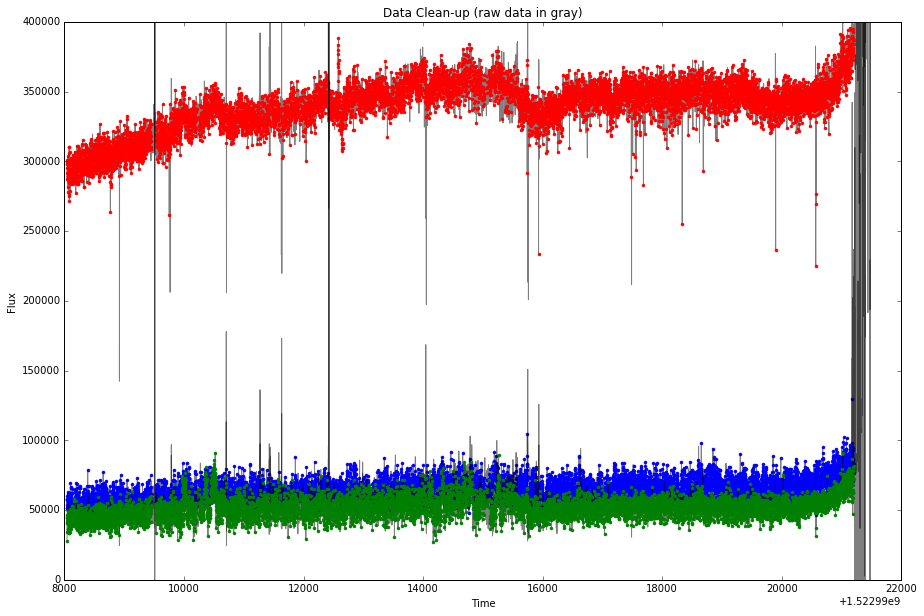

In [73]:
# using pandas df conditionals to clean up the lightcurve

t0 = data.loc['0001','filetime_s'] 
t1 = t0 + 0
t2 = t1 + data.loc[str(len(data)),'filetime_s']
data['gauss_sigma_diff'] = np.abs(data['gauss_params_3_sigma_x']-data['gauss_params_4_sigma_y'])
data2 = data[(data['phot_tyc']>0.) 
             & (data['filetime_s']<24000.) 
             & (data['phot_maxij']>0.)
             & (data['shift_corr_amplitude'] > 4.5)
             & (data['gauss_params_0_amplitude']>12000.)
             & (data['gauss_sigma_diff'] < .5)
             & (data['filetime_s'] > t1)  
             & (data['filetime_s'] < t2)
                 ]
data3 = data[ (data['filetime_s'] > t1)
             & (data['filetime_s'] < t2) 
            ]
# data3 = data
print len(data)
print len(data2)
print len(data3)
fig,ax=plt.subplots(figsize=(15,10))

plt.plot(data3["os_time"],data3['phot_tyc'],'-k',alpha=.5)
plt.plot(data2["os_time"],data2['phot_tyc'],'.r')

plt.plot(data3['os_time'],data3['phot_maxij'],'-k',alpha=.5)
plt.plot(data2['os_time'],data2['phot_maxij'],'.b')

plt.plot(data3['os_time'],data3['phot_ref3']+data3['phot_ref4']+data3["phot_ref5"],'-k',alpha=.5)
plt.plot(data2['os_time'],data2['phot_ref3']+data2['phot_ref4']+data2["phot_ref5"],'.g')

plt.title('Data Clean-up (raw data in gray)')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.ylim([0,4e5])

In [53]:
# check for NaNs and set them to 0 if they exist, ie: 
print np.where(np.isnan(maxij_phot))

#detrend the light curve
# maxi2=lc_detrend(maxij_phot)

(array([2021]),)


/home/amanda/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


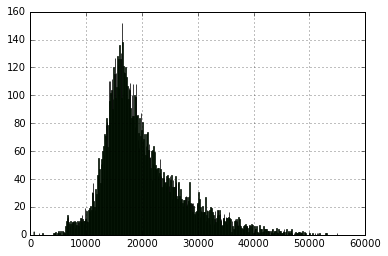

In [71]:
# x = np.diff(data['os_time'])
# x = data['gauss_sigma_diff']
# x = data['shift_corr_amplitude']
x = data['gauss_params_0_amplitude']
# the histogram of the data
n, bins, patches = plt.hist(x, 500, normed=0, facecolor='green', alpha=0.75)

# plt.axis([0., 1.2, 0, 1000])
plt.grid(True) 

In [319]:
#uncleaned data chunk test

ts = np.arange(128)

# step 2: choose t0

t0 = 500
tseries = fID[t0:t0+128]

mphot = data.loc[tseries,'phot_maxij']
f,pmax,pmaxtot = pds_chunk128(ts,mphot,0,128)

tphot = data.loc[tseries,'phot_tyc']
f,ptyc,ptyctot = pds_chunk128(ts,tphot,0,128)


128 1
0 64
128 1
0 64


In [320]:
dumf,dump=logbin(f,pmaxtot/(pmaxtot[0]**0.5),0.05)
dumfr,dumpr=logbin(f,ptyctot/(ptyctot[0]**0.5),0.05)

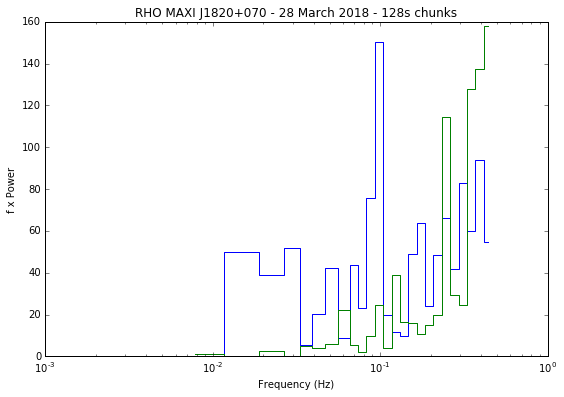

In [326]:
fig,ax=plt.subplots(figsize=(9,6), facecolor='w')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xscale('log')

ax.plot(10.**dumf[dump>0],(10.**dumf[dump>0.0])*dump[dump>0],c='b',drawstyle='steps-mid')
ax.plot(10.**dumfr[dumpr>0],(10.**dumfr[dumpr>0.0])*dumpr[dumpr>0],c='g',drawstyle='steps-mid')


#ax.set_xlim(-2.0,0.65)
# ax.set_ylim(0.,200.)
ax.set_title('RHO MAXI J1820+070 - 28 March 2018 - 128s chunks')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('f x Power')
# ax.plot([0.045,0.045],[0,1200],c='r',linestyle='--')
# ax.plot([0.09,0.09],[0,1200],c='r',linestyle='--')
# ax.plot([0.0225,0.0225],[0,1200],c='y',linestyle='--')

# ax.text(0.1,1000,'MAXI J1820',color='b',size=20)
# ax.text(0.1,400,'Ref Star',color='g',size=20)

In [327]:
#uncleaned data chunk test -- now with >1 chunk

ts = np.arange(11000)

# step 2: choose t0

t0 = 0
tseries = fID[t0:t0+11000]

mphot = data.loc[tseries,'phot_maxij']
f,pmax,pmaxtot = pds_chunk128(ts,mphot,0,11000)

tphot = data.loc[tseries,'phot_tyc']
f,ptyc,ptyctot = pds_chunk128(ts,tphot,0,11000)


11000 86
0 64
11000 86
0 64


In [328]:
f2,p2=p_2_logp(f,pmax,0.03,4)

fig,ax=plt.subplots(figsize=(9,9), facecolor='w')
plt.imshow((10.**f2[:1])*(p2[:,1:]),vmax=40,cmap='viridis',interpolation='none')
plt.plot([4.1,4.1],[0,86],c='r',linestyle='--')
ax.plot([10.25,10.25],[0,86],c='r',linestyle='--')
ax.set_title('RHO MAXI J1820+070 - 28 Mar 2018')

plt.colorbar()

/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


ValueError: could not broadcast input array from shape (0) into shape (35)

add flags column; flags column is an empty list, flags get appended to it 
    EON = end of night
    NaN = not a numbers
    LTZ = zero/less than zero
    SCA = shift correlation amplitude (too small)
    GPA = gassuan parameters amplitude (too small)
    GSD = gaussian sigma difference (too large)

add clean flux boolean column (starts as True, make it false when flagged) 

add local median column too? median of nearest +/-  30 clean datapoints or so 

and then a final clean flux value column with flux for true cleans and local medan for false cleans

if datapoint-to-datapoint (ie, with consecutive file IDs) gaps are > 1.1? 1.25? seconds, then split data (?) and do not fft together because the time will be shifted -- double check logs for these too, leave whitespace gap on 2d plot if it's more than a few seconds


In [ ]:
# 128 big chunks should be in a pd df? 


In [244]:
x = np.array([1, 2, 34, 5, 6,0,55])
xb = x > 0
np.median(x[xb])

5.5

In [300]:
data['clean_flux_bool'] = True

data['localmedian_tyc'] = np.nan
data['localmedian_maxij'] = np.nan
data['localmedian_ref2'] = np.nan
data['localmedian_ref3'] = np.nan
data['localmedian_ref4'] = np.nan
data['localmedian_ref5'] = np.nan
data['localmedian_ref6'] = np.nan

data['clean_flux'] = np.nan

data['flags']=None

In [301]:
print data.loc['0001']

fileID                                                     0001
filename                    maxij_1s_0001_03-25-03_reduced.fits
filetime                                               03-25-03
filetime_s                                                12303
gauss_offset_dx                                        -0.61244
gauss_offset_dy                                        -1.39541
gauss_params_0_amplitude                                34196.9
gauss_params_1_x0                                       14.3876
gauss_params_2_y0                                       13.6046
gauss_params_3_sigma_x                                  1.30573
gauss_params_4_sigma_y                                  1.14099
gauss_params_5_theta                               -1.61489e+07
gauss_params_6_offset                                         0
gauss_sigma_avg                                         1.22336
os_time                                             1.52222e+09
phot_maxij                              